In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from cycler import cycler

### Reaction rates
All values came from [Caughlan](https://ac.els-cdn.com/0092640X88900095/1-s2.0-0092640X88900095-main.pdf?_tid=spdf-27e3214f-37aa-4629-aaa9-17a4130f141c&acdnat=1519621751_dc06dfbb189a47f21e9a03bc78dd10e9) for $T_9 = 0.15$

In [2]:
cs_ta = 1.48e-18
cs_a12 = 4.63e-46
cs_a16 = 1.05e-22

In [3]:
print("{:e}".format(48 / (1e4**2 * 1.48e-18)))

3.243243e+11


In [4]:
perc = [1, 1.3, 0.7]

def helium_usage(t, y, f=1):
    X4, X12, X16, X20 = y
    
    rho = 1e4
    T9 = 0.15
    
    Na2_3a = 1.48e-18
    Na_a12 = 3.03e-17 * f
    Na_a16 = 1.05e-22
    
    
    dX4 =  -rho**2 / 32 * Na2_3a * X4**3 - rho / 12 * Na_a12 * X4 * X12 - rho / 16 * Na_a16 * X4 * X16
    dX12 = rho**2 / 32 * Na2_3a * X4**3 - rho / 4 * Na_a12 * X4 * X12
    dX16 = rho / 3 * Na_a12 * X4 * X12 - rho / 4 * Na_a16 * X4 * X16
    dX20 = 5 * rho / 16 * Na_a16 * X4 * X16
    
    # Convert from seconds to years
    time_conversion = 60 * 60 * 24 * 365 
    return np.multiply([dX4, dX12, dX16, dX20], time_conversion)

def sig1(t, y):
    return helium_usage(t, y, perc[0])
def sig2(t, y):
    return helium_usage(t, y, perc[1])
def sig3(t, y):
    return helium_usage(t, y, perc[2])

sigs = [sig1, sig2, sig3]

In [5]:
span = (1, 1e7)
t = np.linspace(*span, 100)
results = [solve_ivp(sig, t_span=span, y0=(1, 0, 0, 0), t_eval=t) for sig in sigs]

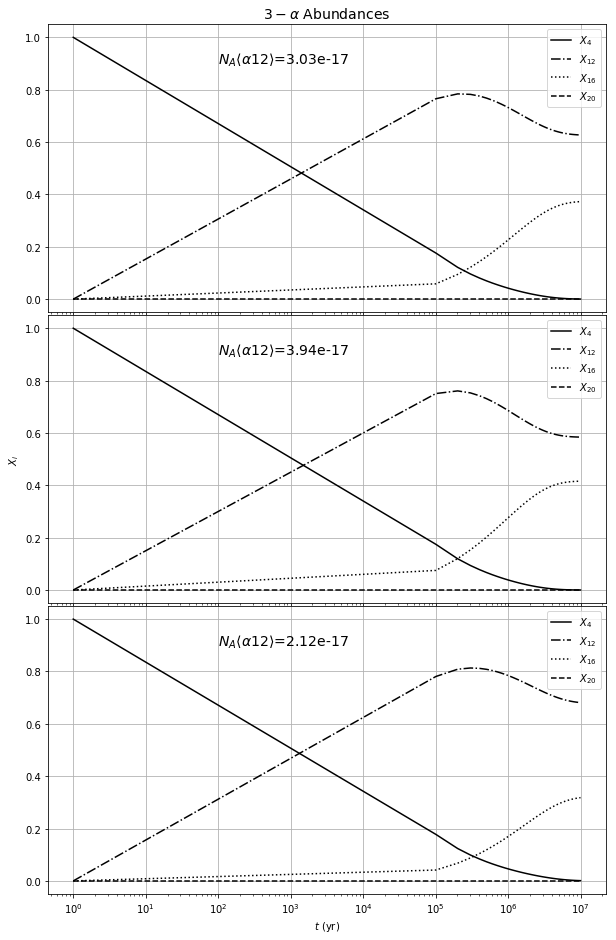

In [6]:
fig, axs = plt.subplots(3, 1, sharex=True)
fig.set_size_inches((10, 16))
axs[0].set_title(r'$3-\alpha$ Abundances', fontsize=14)

labels = [r'$X_4$', r'$X_{12}$', r'$X_{16}$', r'$X_{20}$']
axs[2].set_xlabel(r'$t$ (yr)')


cycle = (cycler('color', ['k']) * cycler('linestyle', ['-', '-.', ':', '--']))

vals = [3.03e-17 * f for f in perc]
axs[1].set_ylabel(r'$X_i$')
for i, (ax, res, val) in enumerate(zip(axs ,results, vals)):
    ax.set_prop_cycle(cycle)
    ax.set_xscale('linear')
    ax.grid()
    [ax.semilogx(res.t, y, label=label) for y, label in zip(res.y, labels)]
    ax.annotate(rf'$N_A \langle \alpha 12 \rangle$={val:.2e}', (1e2,.9), fontsize=14)
    ax.legend()
     
plt.subplots_adjust(hspace=0.01)

## Problem 2

In [7]:
rho = 2e5 # g cm-3
mu_e = 2
B = 9.739e5 # g cm-3
x = (rho / mu_e / B) ** (1/3)
cv_He = 9.35e7 # erg g-1 K-1
cv_e_const = 2 * 1.35e5 / rho * x * np.sqrt(1 + x**2) # erg g-1 K-2
Y = 1
trip_a_const = 5.1e8 * rho**2 * Y ** 3 # erg g-1 s-1 GK3

def temperature(t, y):
    T = y
    T9 = T / 1e9
    lhs = trip_a_const * T9 ** (-3) * np.exp(-4.4027 / T9)
    rhs = cv_He + cv_e_const * T
    dTdt = lhs / rhs
    
    # Convert to days
    tc = 60 * 60 * 24
    return dTdt * tc

In [8]:
span = (0, 30)
t = np.linspace(*span, 1000)
result = solve_ivp(temperature, span, (1.5e8,), t_eval=t)

Text(0,0.5,'$T_9$ (K)')

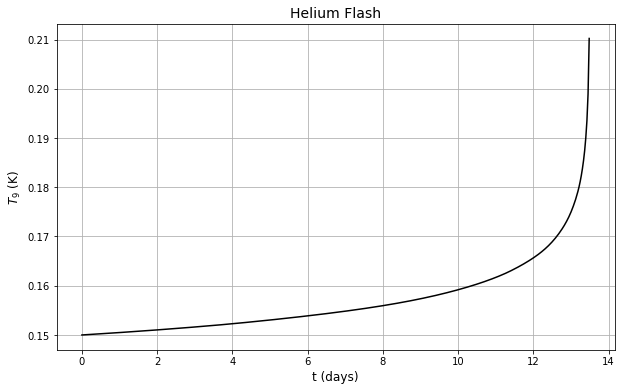

In [16]:
degen = (rho / mu_e / 6e-9)**(2/3)
mask = result.y[0] < degen

plt.figure(figsize=(10, 6))
plt.plot(result.t[mask], result.y[0][mask] / 1e9, 'k')

plt.grid()

plt.title('Helium Flash', fontsize=14)
plt.xlabel('t (days)', fontsize=12)
plt.ylabel(r'$T_9$ (K)', fontsize=12)